In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import gamma
import scipy.integrate
import pandas
import math

# TO DO: Update to most recent Planck results
from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [2]:
# Path to tables of cosmic variance values
path = "../CV_Vals/"

# Get young, blue galaxy spectrum
data = np.loadtxt("erb2010_continuum.dat")
x = data[:,0]
y = data[:,1] * x**2 / 3e18 # Convert to correct flux values

# Constants
tot_sky = 41253. # Total degrees on the sky
masses = np.array([7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0]) # Mass bins in log(M/Msun)

# TO DO: Modify cosmic variance values from the tables such that masses <= 8 use the same cosmic variance values as 8.5
# Currently the CV values are incorrectly extrapolated to lower masses from a mass of 8.5
# The code used to calculated the CV values is called "getcv" and is included with the CV value files

trials = 10000 # Number of trials for calculating median from gamma function

In [3]:
# Function to find closest wavelength in measured galaxy spectrum compared to given value
def nearest_wavelength(x, val):
    i = (np.abs(x - val)).argmin()
    return x[i]

In [4]:
# Define a class for different survey designs
class survey:
    def __init__(self, ABmax, area, cv_file, wavelength = 0, num_pointings = 1):
        self.ABmax = ABmax # Limiting AB magnitude of the survey
        self.area = area # Survey area
        self.file = cv_file # Name of cosmic variance table file
        self.point = num_pointings # Number of independent pointings
        self.wavelength = wavelength # Center wavelength for the chosen filter

In [5]:
# Method to take one trial of a gamma distribution with a given variance and mean
# This should be double-checked
def trial(sig_v, mean, trials=1):
    var = sig_v**2*mean**2
    k = mean**2/var
    t = var/mean
    rand = np.rint(np.random.gamma(k, scale=t, size=trials))
    return rand

In [6]:
# n=int(10e3)
# sig=2.9854648729904394
# mean=10
# trials=trial(sig, mean, n)
# fig, ax=plt.subplots(figsize=(12,9))
# xmax=max(trials)
# b=100
# if xmax-1<100:
#     b=math.ceil(xmax-1)
# ax.hist(trials, bins=b, range=(0,xmax), histtype='step', density=0)
# ax.set(xlim=(0,xmax),yscale='log')
# print(np.mean(trials),np.std(trials),(sig*mean))

In [24]:
# Find mean, median number of galaxies found for a given survey design
def mean_median(survey, correction = True):
        
    # Get survey information
    point = survey.point
    survey_area = survey.area * point
    ABmax = survey.ABmax 
    
    # Absolute magnitude range over which to integrate
    # Range is larger than necessary to include all galaxies
    M = np.linspace(-30, 0, 1000)
    
    # Redshift values from CV calculations 
    df = pandas.read_csv(path+survey.file)
    z_vals = df["z"].values
    z_vals = z_vals[::-1]

    all_mean = []
    all_sig_v = []
    
    # Loop over z values
    for z in z_vals:
        
        # Correct magnitude to account for choice of telescope filter
        if(correction):
            # Get observed wavelength for a rest frame of 1600 Angstroms
            # Find closest wavelength to this value in the observed galaxy spectrum
            wl_obs = nearest_wavelength(x, 1600 * (1 + z))
            # Account for difference in observed magnitude due to difference in wavelength 
            # of the survey and the wavelength of the observed?
            ABmax_new = ABmax + 2.5 * np.log10(y[x==survey.wavelength]/y[x==wl_obs])
        else:
            ABmax_new = ABmax
        
        # Find volume of space within redshift bin
        dz = df.loc[df['z'] == z][["dz"]].values[0][0]
        vol = cosmo.comoving_volume(z + dz/2).value - cosmo.comoving_volume(z - dz/2).value

        # Apparent magnitude range over which to integrate
        m = M + cosmo.distmod(z).value
        
        # Schechter Extrapolation (Bouwens et al. 2015)
        Ms = -20.95 + 0.01 * (z - 6)
        p = 0.47 * 10**(-0.27 * (z - 6)) * 10**(-3)
        a = -1.87 - 0.1 * (z - 6)
        LF_center = np.log(10)/2.5 * p * (10**(0.4 * (Ms - M)))**(a+1) * np.exp(-10**(0.4 * (Ms - M)))
            # TO DO: Update so that redshifts >= 8 use the same mass-luminosity relation
            # but for z < 8 use mass-luminosity relation (all relations given in Song et al. 2016)
            #Done
        if z>=8:
            Ms = -20.95 + 0.01 * (8 - 6)
            p = 0.47 * 10**(-0.27 * (8 - 6)) * 10**(-3)
            a = -1.87 - 0.1 * (8 - 6)
            LF_center = np.log(10)/2.5 * p * (10**(0.4 * (Ms - M)))**(a+1) * np.exp(-10**(0.4 * (Ms - M)))

        means = []
        meds = []
        sigs = []
        max_mass=np.max(masses)
        # Loop over all mass bins
        for mass in masses:
            
            # Account for difference between Song and Bouwens wavelength
            diff = 2.5 * np.log10(y[x==nearest_wavelength(x,1500)]/y[x==nearest_wavelength(x,1600)])
           
            # Apparent magnitude limits for given mass bin using Song et al. 2016
            
            u_lim = 2. * (-1.56 - mass) + cosmo.distmod(z).value + diff # Dimmest object
            l_lim = 2. * (-1.56 - (mass + 0.5)) + cosmo.distmod(z).value + diff # Brightest object
            u_lim = min(u_lim, ABmax_new) # Compare dimmest object to telescope limit  
            
            # Find where apparent magnitude is within limits
            if mass == max_mass:
                index = np.where(m <= u_lim)
            else:   
                index = np.where((m >= l_lim) & (m <= u_lim))

            # Modify index for integration
            if index[0].size != 0:
                index[0][-1] = index[0][-1] + 1

            # Integrate luminosity function over apparent magnitude to get number density
            int_center = np.trapz(LF_center[index], m[index])
            
            # Multiply by volume to get number
            means.append(int_center * vol * survey_area / tot_sky)
            
            # Get cosmic variance value for this z value and mass bin
            # CV values calculated as in Moster et al. 2010
            if z<8:
                sig_v = df.loc[df['z'] == z][[str(mass)]].values[0][0] / np.sqrt(point)
                sigs.append(sig_v)
        # Append mean and variance values of all masses for this redshift 
        all_mean.append(means)
        all_sig_v.append(sigs)
        
    all_tot_mean = []
    all_med = []
    
    # Loop over all z values (high to low)
    for i in range(len(z_vals)):
        tot_mean = 0
        tot_trials = np.zeros(trials)
        # Find cumulative mean and median number of observed galaxies up to z
        for j in range(i+1):
            means = all_mean[j]
            sigs = all_sig_v[j]
            # Run trials of gamma distribution to find median
            for k in range(len(masses)):
                if means[k] != 0:
                    one_trial = trial(sigs[k], means[k], trials)
                    tot_trials += one_trial
                    tot_mean += means[k]
        all_tot_mean.append(tot_mean)
        med = np.median(tot_trials)
        all_med.append(med)
        
    return np.array(all_tot_mean), np.array(all_med), z_vals

# Plots

In [25]:
# %%timeit
# Survey design matching the idealized survey from Mashian et al. 2015

mashian = survey(31.5, 200./3600, "cv_mashian.csv")
mean_mashian, med_mashian, z_vals_mashian = mean_median(mashian, correction = False)

(0.1, 50.0)

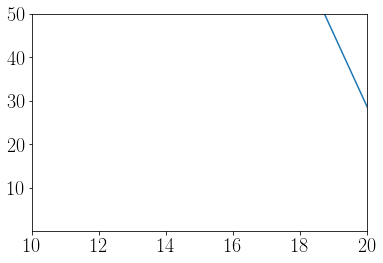

In [28]:
plt.plot(z_vals_mashian, mean_mashian)
plt.xlim(10,20)
plt.ylim(0.1,50)

Text(0.5, 1.0, 'Mashian')

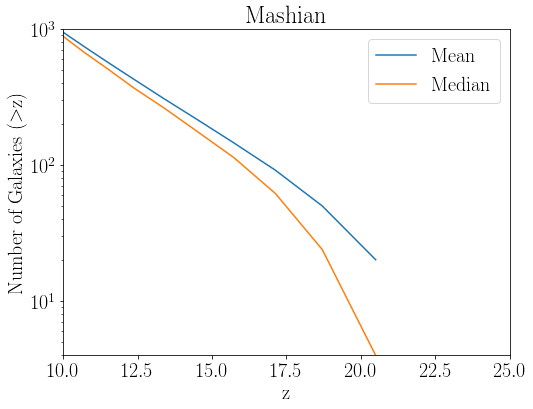

In [33]:
fig = plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_mashian, mean_mashian, label = "Mean")
plt.plot(z_vals_mashian, med_mashian, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()

plt.ylim(min(med_mashian), 1000)
plt.xlim(10, 25)

plt.title("Mashian")

#plt.savefig("Plots/ideal_highmass_fix.pdf")

In [34]:
# Survey design matching the JADES Deep survey from Williams et al. 2018 (pg. 36)

deep = survey(30.7, 46./3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4))
mean_deep, med_deep, z_vals_deep = mean_median(deep)

Text(0.5, 1.0, 'JADES Deep')

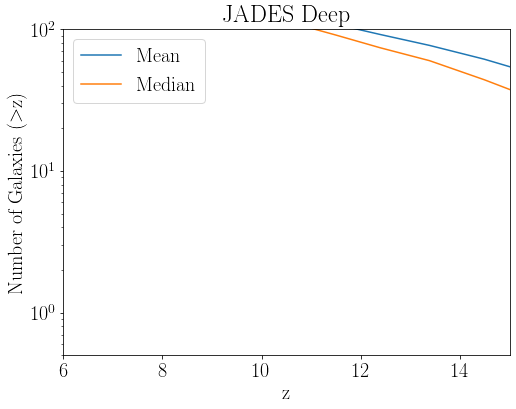

In [35]:
fig = plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_deep, mean_deep, label = "Mean")
plt.plot(z_vals_deep, med_deep, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()

plt.ylim(0.5, 100)
plt.xlim(6,15)

plt.title("JADES Deep")

#plt.savefig("Plots/deep_highmass_fix.pdf")

In [14]:
# Survey design matching the JADES Wide survey from Williams et al. 2018 (pg. 36)

wide = survey(29.8, 190./3600, "cv_jades_wide.csv", nearest_wavelength(x,14873.4))
mean_wide, med_wide, z_vals_wide = mean_median(wide)

Text(0.5, 1.0, 'JADES Wide')

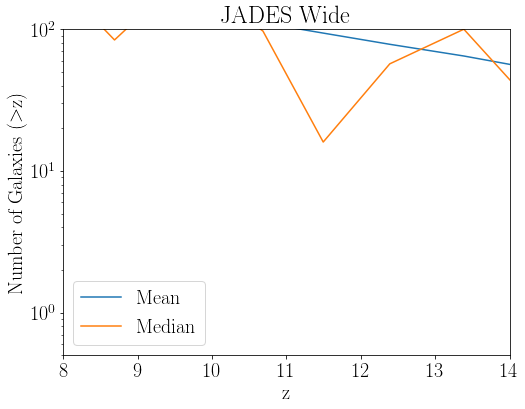

In [15]:
fig = plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_wide, mean_wide, label = "Mean")
plt.plot(z_vals_wide, med_wide, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()

plt.ylim(0.5, 100)
plt.xlim(8,14)

plt.title("JADES Wide")

#plt.savefig("Plots/wide_highmass_fix.pdf")

In [16]:
# Survey design assuming 35 parallel pointings of JWST
# Uses limiting magnitude from JADES Deep, area of one JWST pointing

parallel_35 = survey(30.7, 4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 35)
mean_35, med_35, z_vals_35 = mean_median(parallel_35)

Text(0.5, 1.0, '35 Pointings')

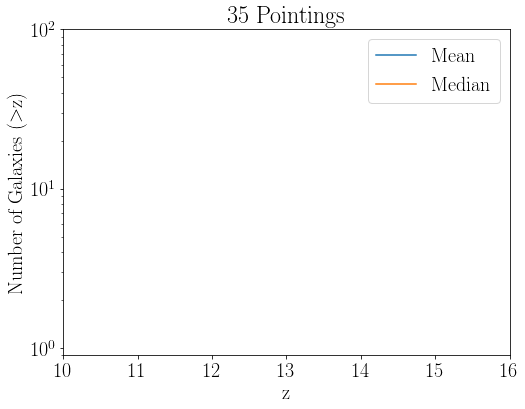

In [17]:
fig = plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_35, mean_35, label = "Mean")
plt.plot(z_vals_35, med_35, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()

plt.ylim(0.9, 100)
plt.xlim(10,16)

plt.title("35 Pointings")

# Survey design assuming 35 parallel pointings of JWST#plt.savefig("35.pdf")

In [18]:
# Survey design assuming 200 parallel pointings of JWST

parallel_200 = survey(30.7, 4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 200)
mean_200, med_200, z_vals_200 = mean_median(parallel_200)

Text(0.5, 1.0, '200 Pointings')

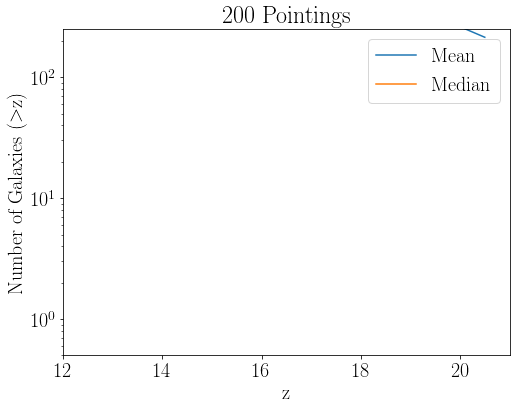

In [19]:
fig = plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_200, mean_200, label = "Mean")
plt.plot(z_vals_200, med_200, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()

plt.ylim(0.5, 250)
plt.xlim(12,max(z_vals_200)+0.5)

plt.title("200 Pointings")

#plt.savefig("200.pdf")

In [20]:
# Survey design assuming 2000 parallel pointings of JWST

parallel_2000 = survey(30.7, 4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 2000)
mean_2000, med_2000, z_vals_2000 = mean_median(parallel_2000)

Text(0.5, 1.0, '2000 Pointings')

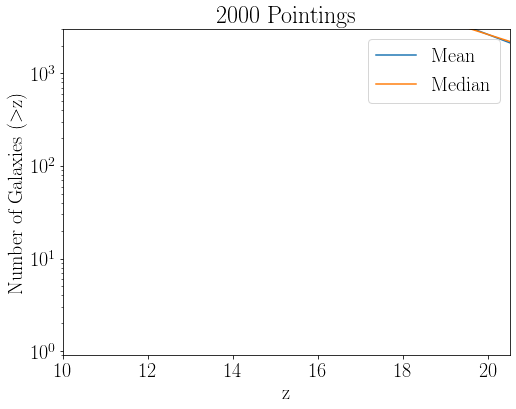

In [21]:
fig = plt.figure(figsize = (8, 6))
ax = plt.axes()
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_2000, mean_2000, label = "Mean")
plt.plot(z_vals_2000, med_2000, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()

plt.ylim(0.9, 3000)
plt.xlim(10, max(z_vals_2000))

plt.title("2000 Pointings")

#plt.savefig("Cumulative_Plots/2000.pdf")

In [22]:
# Survey design modeling the effect of lensing by increasing limiting magnitude of JADES Deep survey by 2
# Assumes this is over one JWST pointing

lensing_2 = survey(30.7 + 2, 4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1)
mean_lens, med_lens, z_vals_lens = mean_median(lensing_2)

Text(0.5, 1.0, 'Lensing, +2 Mag')

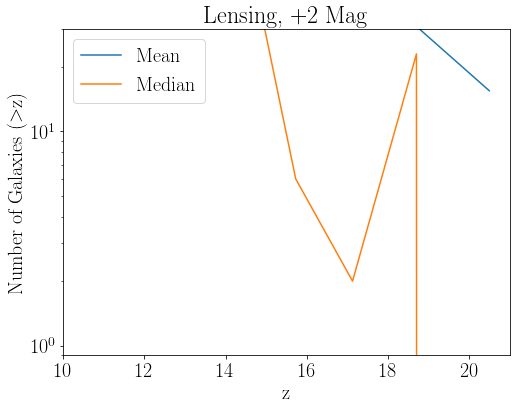

In [23]:
fig = plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

plt.plot(z_vals_lens, mean_lens, label = "Mean")
plt.plot(z_vals_lens, med_lens, label = "Median")

plt.xlabel("z")
plt.ylabel("Number of Galaxies"r" ($>$z)")
plt.yscale("Log")

plt.legend()

plt.ylim(0.9, 30)
plt.xlim(10, max(z_vals_lens)+0.5)

plt.title("Lensing, +2 Mag")

#plt.savefig("Cumulative_Plots/lensing.pdf")